In [218]:
import os
import time
import json
import numpy as np
import pandas as pd
from scipy import stats
import random
from dotenv import load_dotenv
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage

In [219]:
import matplotlib.pyplot as plt
import seaborn as sns

In [220]:
# Cargar variables de entorno
load_dotenv()
client = MistralClient(api_key="XEV0fCx3MqiG9HqVkGc4Hy5qyD3WwPHr")

In [221]:
# 1. Cargar el corpus de conocimiento
def load_corpus(corpus_path='../data/processed/normalized_data.json'):
    """Carga el corpus de conocimiento desde un archivo JSON"""
    with open(corpus_path, 'r', encoding='utf-8') as f:
        return json.load(f)

In [222]:
# Funciones de visualización para el análisis de bootstrapping
def plot_bootstrap_distribution(analysis, bootstrap_means):
    """Genera gráficas para visualizar la distribución del bootstrapping"""
    plt.style.use('seaborn-v0_8')
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Distribución de medias bootstrap
    plt.subplot(2, 1, 1)
    sns.histplot(data=bootstrap_means, bins=30, color='skyblue', alpha=0.6)
    plt.axvline(analysis['bootstrap_mean'], color='red', linestyle='--', 
                label=f'Media Bootstrap ({analysis["bootstrap_mean"]:.2f})')
    plt.axvline(analysis['ci_95_lower'], color='green', linestyle=':', 
                label=f'IC 95% ({analysis["ci_95_lower"]:.2f}, {analysis["ci_95_upper"]:.2f})')
    plt.axvline(analysis['ci_95_upper'], color='green', linestyle=':')
    plt.title('Distribución de Medias por Bootstrap')
    plt.xlabel('Puntuación')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Gráfica de barras con intervalos de confianza
    plt.subplot(2, 1, 2)
    comparisons = ['Muestra Original', 'Bootstrap']
    means = [analysis['original_mean'], analysis['bootstrap_mean']]
    errors = [analysis['original_std'], 
              (analysis['ci_95_upper'] - analysis['ci_95_lower']) / 2]
    
    bars = plt.bar(comparisons, means, yerr=errors, capsize=5, 
                   color=['lightcoral', 'skyblue'], alpha=0.6)
    
    # Añadir valores sobre las barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')
    
    plt.title('Comparación de Medias: Original vs Bootstrap')
    plt.xlabel('Método')
    plt.ylabel('Puntuación')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_evaluation_heatmap(results_df):
    """Genera un heatmap de puntuaciones por pregunta"""
    plt.figure(figsize=(12, 8))
    
    # Crear matriz de puntuaciones (ya es DataFrame, no necesita to_frame())
    eval_data = results_df.pivot_table(
        index='pregunta',
        values='evaluacion',
        aggfunc='first'
    ).sort_values('evaluacion', ascending=False)
    
    # Crear heatmap - elimina .to_frame() ya que eval_data ya es DataFrame
    sns.heatmap(eval_data,  # <-- Cambio principal aquí
                cmap='YlOrRd',
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Puntuación'})
    
    plt.title('Mapa de Calor de Puntuaciones por Pregunta')
    plt.ylabel('Preguntas')
    plt.tight_layout()
    
    return plt.gcf()

In [223]:
# Funciones de procesamiento de respuestas
def extract_content_from_response(response):
    """Extrae el contenido real de una respuesta que puede contener metadatos"""
    if isinstance(response, str):
        return response
    return str(response)

def clean_response(resp):
    """Limpia y normaliza una respuesta"""
    if not isinstance(resp, str):
        return ""
    # Limpiar caracteres especiales y espacios extra
    cleaned = resp.strip().replace('\n', ' ').replace('\r', ' ')
    while '  ' in cleaned:
        cleaned = cleaned.replace('  ', ' ')
    return cleaned

def process_response(response):
    """Procesa una respuesta extrayendo el contenido y limpiándolo"""
    return clean_response(extract_content_from_response(response))

# Procesamiento de Respuestas

El notebook ha sido actualizado para manejar correctamente las respuestas del chatbot que incluyen metadatos. Las principales mejoras son:

1. **Extracción de contenido**: Se extrae el contenido real de las respuestas que vienen en formato completo de Mistral
2. **Limpieza de respuestas**: Se normalizan los espacios y caracteres especiales
3. **Evaluación robusta**: La evaluación de similitud ahora maneja mejor diferentes formatos de respuesta
4. **Fallback automático**: Si hay errores en la evaluación principal, se usa una métrica de similitud de coseno como respaldo

Esto asegura que la comparación se realice solo sobre el contenido relevante de las respuestas.

In [224]:
# 2. Generar preguntas basadas en el corpus
def generate_corpus_questions(corpus, n=30):
    """Genera preguntas relevantes basadas en el corpus usando Mistral AI"""
    # Extraer información clave del corpus para construir un contexto
    cities = set()
    attractions = set()
    unique_titles = set()
    
    for entry in corpus:
        cities.add(entry['city'])
        if entry.get('attractions'):
            attractions.update(entry['attractions'])
        if entry.get('title'):
            # Limpiar título eliminando caracteres especiales
            title = entry['title'].replace('\r', '').replace('\n', '').replace('\t', '').strip()
            if title and len(title) < 100:  # Filtrar títulos muy largos
                unique_titles.add(title)
    
    # Construir contexto para el prompt
    context = f"""
    Estás generando preguntas turísticas sobre Cuba basadas en este contexto:
    - Ciudades mencionadas: {', '.join(cities)}
    - Atracciones turísticas: {', '.join(attractions) if attractions else 'No especificadas'}
    - Lugares destacados: {', '.join(unique_titles) if unique_titles else 'No especificados'}
    
    Genera preguntas que:
    1. Sean relevantes para la información en el corpus
    2. Cubran diferentes aspectos del turismo en Cuba
    3. Sean específicas pero naturales (como las haría un turista)
    4. Incluyan referencias a ciudades, atracciones y conceptos del contexto
    5. Referentes a estos temas solamente: gastronomía, vida nocturna, 
    lugares históricos y alojamiento
    """
    
    # Crear prompt para Mistral AI
    prompt = f"""
    {context}
    
    Genera EXACTAMENTE {n} preguntas sobre turismo en Cuba usando este formato:
    [PREGUNTA 1]
    [PREGUNTA 2]
    ...
    [PREGUNTA {n}]
    
    Reglas:
    - Solo incluye la pregunta sin numeración
    - Usa diferentes tipos de preguntas (qué, dónde, cómo)
    - Refiérete específicamente a: {', '.join(list(cities)[:5])}...
    """
    
    try:
        print("generando preguntas...")
        # Obtener respuesta de Mistral AI
        response = client.chat(
            model="mistral-large-latest",
            messages=[{"role": "user", "content": prompt}]
        )
        
        print("preguntas generadas...")
        
        # Procesar las preguntas generadas
        content = response.choices[0].message.content
        questions = []
        
        for line in content.split('\n'):
            clean_line = line.strip()
            if clean_line and clean_line.endswith('?'):
                questions.append(clean_line)
        
        # Asegurarnos de tener exactamente n preguntas
        if len(questions) >= n:
            return questions[:n]
        else:
            # Generar preguntas de respaldo si no hay suficientes
            base_questions = []
            return base_questions[:n]
            
    except Exception as e:
        print(f"Error generando preguntas: {str(e)}")

In [225]:
def analyze_with_bootstrapping(results, n_bootstraps=1000, sample_size=300):
    """Realiza análisis estadístico con bootstrapping y genera visualizaciones"""
    quality_scores = [res['evaluacion'] for res in results]
    
    # Estadísticas originales
    original_mean = np.mean(quality_scores)
    original_std = np.std(quality_scores)
    
    # Bootstrapping para simular muestras más grandes
    bootstrap_means = []
    for _ in range(n_bootstraps):
        sample = np.random.choice(quality_scores, size=sample_size, replace=True)
        bootstrap_means.append(np.mean(sample))
    
    # Intervalo de confianza
    ci_lower = np.percentile(bootstrap_means, 2.5)
    ci_upper = np.percentile(bootstrap_means, 97.5)
    
    analysis = {
        "original_mean": original_mean,
        "original_std": original_std,
        "bootstrap_mean": np.mean(bootstrap_means),
        "bootstrap_std": np.std(bootstrap_means),
        "ci_95_lower": ci_lower,
        "ci_95_upper": ci_upper,
        "n_bootstraps": n_bootstraps,
        "sample_size": sample_size
    }
    
    # Generar visualizaciones
    fig_dist = plot_bootstrap_distribution(analysis, bootstrap_means)
    
    # Crear DataFrame para el heatmap
    results_df = pd.DataFrame(results)
    fig_heat = plot_evaluation_heatmap(results_df)
    
    # Guardar las gráficas
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    fig_dist.savefig(f'bootstrap_distribution_{timestamp}.png', dpi=300, bbox_inches='tight')
    fig_heat.savefig(f'quality_heatmap_{timestamp}.png', dpi=300, bbox_inches='tight')
    
    print("\n=== Resultados del Análisis ===")
    print(f"Muestra Original (n={len(quality_scores)}):")
    print(f"- Media: {original_mean:.2f}/5")
    print(f"- Desviación Estándar: {original_std:.2f}")
    print(f"\nBootstrap ({n_bootstraps} iteraciones de tamaño {sample_size}):")
    print(f"- Media Estimada: {analysis['bootstrap_mean']:.2f}/5")
    print(f"- Intervalo de Confianza 95%: [{ci_lower:.2f}, {ci_upper:.2f}]")
    
    return analysis

In [226]:
# 5. Evaluación de similitud semántica
def calculate_precision(query, response):
    """Evalúa la puntuacion respuestas"""
    prompt = f"""
    Como experto en turismo en Cuba, analiza esta respuesta a la pregunta dada sobre turismo en Cuba:
    
    Pregunta: {query}
    Respuesta: {response}
    
    Evalúa considerando:
    1. Precisión de la información
    2. Coherencia y relevancia
    3. Cobertura del tema
    4. Calidad de las recomendaciones
    5. Ajuste a la pregunta realizada
    
    Asigna una puntuación:
    - 0: Respuesta totalmente errónea
    - 1: Mucha alucinación e invención, pero pocos datos reales
    - 2: Alguna parte de la información es real y cierta, aunque sigue alucinando
    - 3: Bastante de lo que dice es cierto, pero le falta calidad en la respuesta
    - 4: Mucho de lo que dice es cierto, tiene buenas recomendaciones, pero aún necesita abarcar un poco más
    - 5: Todo o casi todo tiene sentido, es cierto y además es bastante completa la información, incluyendo 
    recomendaciones buenas

    Devuelve SOLO un número entre 0 y 5.
    """
    
    try:
        response = client.chat(
            model="mistral-large-latest",
            messages=[ChatMessage(role="user", content=prompt)],
            max_tokens=10
        )
        return float(response.choices[0].message.content.strip())
    except:
        # Fallback: similitud de coseno básica
        from sklearn.feature_extraction.text import TfidfVectorizer
        vectorizer = TfidfVectorizer().fit_transform([response])
        return ((vectorizer * vectorizer.T).A[0,1] * 10)

In [227]:
# 7. Flujo principal de evaluación
def run_evaluation(corpus_path='corpus.json', n_questions=30):
    """Ejecuta el proceso completo de evaluación"""
    # Verificar si ya existen preguntas
    try:
        existing_questions = pd.read_csv('questions.csv')
        if not existing_questions.empty:
            questions = existing_questions['pregunta'].tolist()
            print(f"Se encontraron {len(questions)} preguntas existentes en questions.csv")
        else:
            raise FileNotFoundError
    except:
        print("Generando nuevas preguntas...")
        corpus = load_corpus(corpus_path)
        questions = generate_corpus_questions(corpus, n_questions)
        pd.DataFrame({'pregunta': questions}).to_csv('questions.csv', index=False)
        print(f"Se generaron {len(questions)} preguntas nuevas y se guardaron en questions.csv")
    
    # Función para extraer el contenido de la respuesta
    def extract_response_content(response_str):
        try:
            if 'content=' in response_str:
                # Buscar el contenido entre content=' y ', name=
                start = response_str.find("content='") + 9
                end = response_str.find("', name=")
                if start > 8 and end > start:  # Si encontramos ambos marcadores
                    return response_str[start:end]
            return response_str
        except:
            return response_str

    # Si ya tenemos respuestas manuales, continuar con la evaluación
    try:
        # Cargar desde JSON
        with open('responses.json', 'r', encoding='utf-8') as f:
            results_data = json.load(f)
        
        # Convertir a DataFrame
        manual_df = pd.DataFrame(results_data)
        
        # Verificar consistencia
        if len(manual_df) != len(questions):
            raise ValueError(f"Número de respuestas ({len(manual_df)}) no coincide con preguntas ({len(questions)})")
        
        # Verificar estructura
        if 'pregunta' not in manual_df.columns or 'respuesta' not in manual_df.columns:
            raise ValueError("Formato JSON inválido: faltan campos requeridos")
            
        # Procesar respuestas (si es necesario)
        if 'respuesta' in manual_df.columns:  # Para compatibilidad con versiones anteriores
            manual_df['respuesta'] = manual_df['respuesta'].apply(extract_response_content)
        else:
            manual_df['respuesta'] = manual_df['respuesta'].apply(extract_response_content)

    except Exception as e:
        print(f"Error procesando respuestas: {str(e)}")
        # Crear plantilla nueva en formato JSON
        results_data = [
            {"pregunta": q, "respuesta": ""} 
            for q in questions
        ]
        
        # Guardar plantilla
        with open('responses.json', 'w', encoding='utf-8') as f:
            json.dump(results_data, f, ensure_ascii=False, indent=2)
        
        print("Se creó nueva plantilla en 'responses.json'")
        return
    
    results = []
    print("\nIniciando evaluación con Mistral AI...")
    
    for i, row in manual_df.iterrows():
        max_retries = 3
        retry_delay = 2
        
        for attempt in range(max_retries):
            try:
                print(f"Procesando pregunta {i+1}/{len(manual_df)}")
                question = row['pregunta']
                response = row['respuesta'].strip()
                
                if not response:
                    print(f"Advertencia: Respuesta vacía para pregunta {i+1}")
                    continue
                
                evaluation = calculate_precision(question, response)
                
                results.append({
                    'pregunta': question,
                    'respuesta': response,
                    'evaluacion': evaluation
                })
                
                # Rate limiting adaptativo
                time.sleep(2.0)  # Base delay
                break  # Si llegamos aquí, todo salió bien
                
            except Exception as e:
                print(f"Error en pregunta {i+1}, intento {attempt + 1}: {str(e)}")
                if attempt < max_retries - 1:
                    time.sleep(retry_delay * (attempt + 1))  # Backoff exponencial
                else:
                    print(f"Error máximo de intentos para pregunta {i+1}")
    
    # Análisis estadístico
    analysis = analyze_with_bootstrapping(results)
    
    # Guardar resultados completos
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"resultados_completos_{timestamp}.csv", index=False)
    
    # Guardar análisis estadístico
    analysis_df = pd.DataFrame([analysis])
    analysis_df.to_csv(f"analisis_estadistico_{timestamp}.csv", index=False)
    
    print("\n" + "="*50)
    print("RESULTADOS FINALES")
    print("="*50)
    print(f"Calidad promedio (30 preguntas): {analysis['original_mean']:.2f} ± {analysis['original_std']:.2f}")
    print(f"Calidad estimada ({analysis['sample_size']} preguntas simuladas): {analysis['bootstrap_mean']:.2f}")
    print(f"Intervalo de confianza 95%: [{analysis['ci_95_lower']:.2f}, {analysis['ci_95_upper']:.2f}]")
    
    return results_df, analysis_df


Se encontraron 30 preguntas existentes en questions.csv

Iniciando evaluación con Mistral AI...
Procesando pregunta 1/30
Procesando pregunta 2/30
Procesando pregunta 3/30
Procesando pregunta 4/30
Procesando pregunta 5/30
Procesando pregunta 6/30
Procesando pregunta 7/30
Procesando pregunta 8/30
Procesando pregunta 9/30
Procesando pregunta 10/30
Procesando pregunta 11/30
Procesando pregunta 12/30
Procesando pregunta 13/30
Procesando pregunta 14/30
Procesando pregunta 15/30
Procesando pregunta 16/30
Procesando pregunta 17/30
Procesando pregunta 18/30
Procesando pregunta 19/30
Procesando pregunta 20/30
Procesando pregunta 21/30
Procesando pregunta 22/30
Procesando pregunta 23/30
Procesando pregunta 24/30
Procesando pregunta 25/30
Procesando pregunta 26/30
Procesando pregunta 27/30
Procesando pregunta 28/30
Procesando pregunta 29/30
Procesando pregunta 30/30

=== Resultados del Análisis ===
Muestra Original (n=30):
- Media: 4.13/5
- Desviación Estándar: 0.62

Bootstrap (1000 iteraciones de

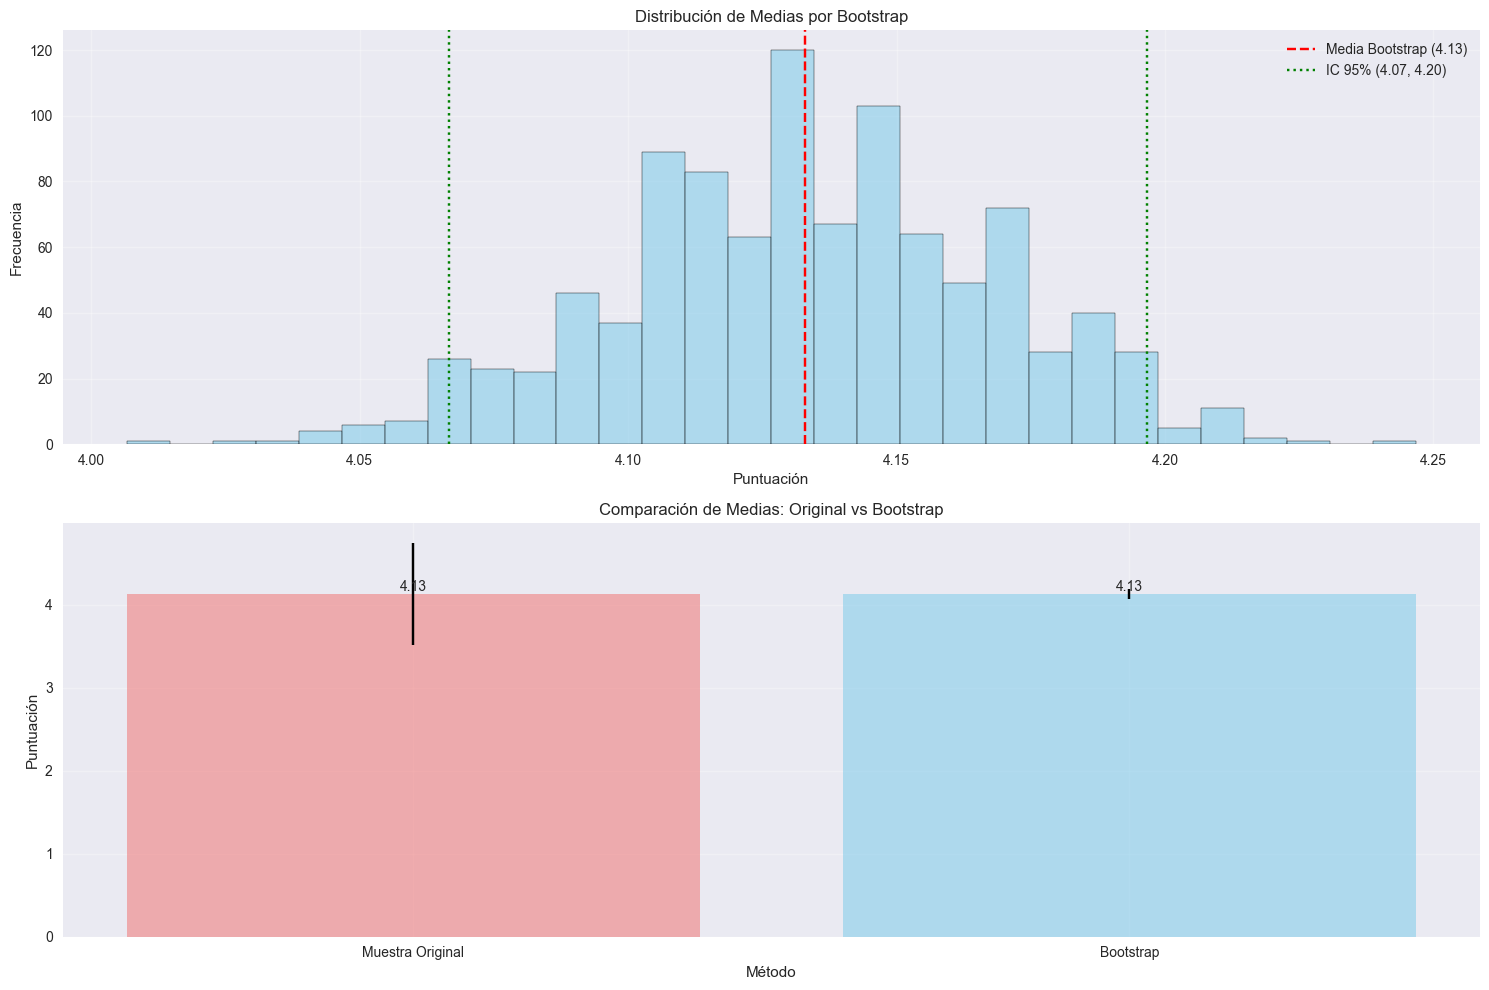

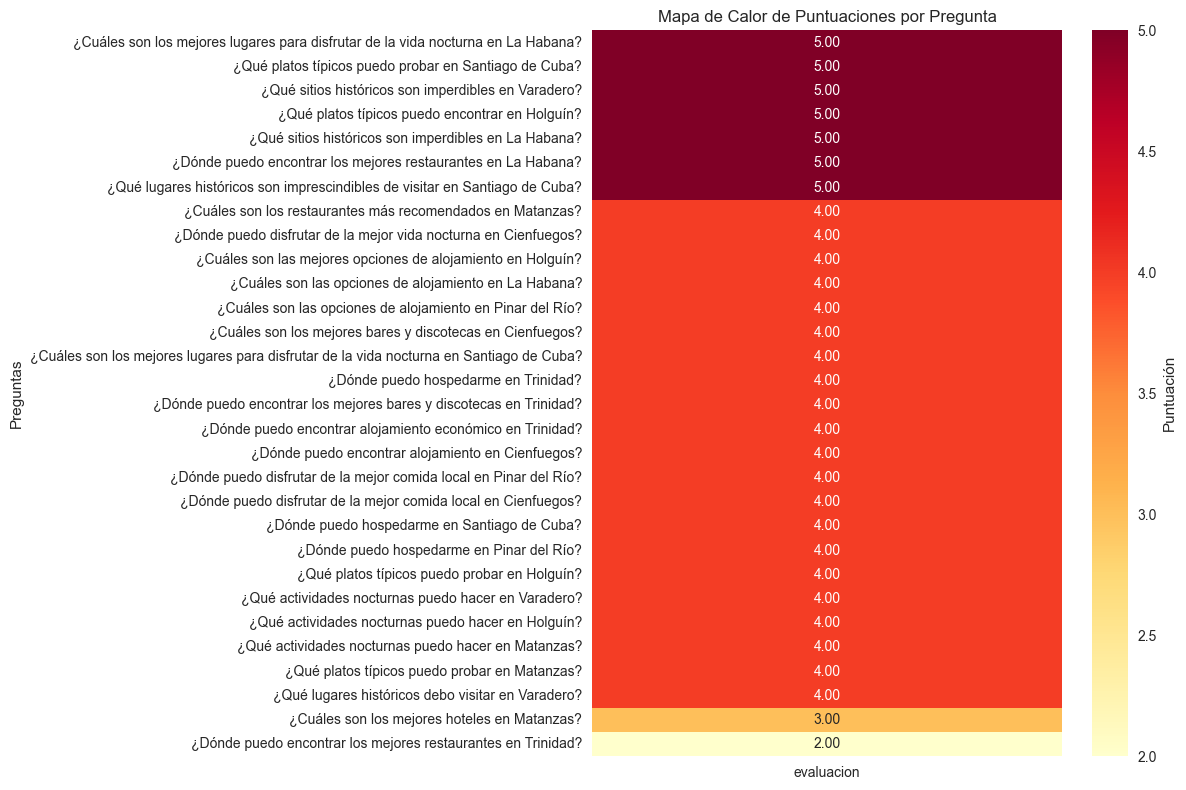

In [228]:
# Ejecutar la evaluación
# NOTA: La primera ejecución genera el CSV para respuestas manuales
# La segunda ejecución (después de completar el CSV) realiza la evaluación completa
results, analysis = run_evaluation(corpus_path='../data/processed/normalized_data.json', n_questions=4)